<h1>Relatório: Aprendizado de máquina e reconhecimento de padrões</h1>
<h3>Aluno: André de Sousa Araújo</h3>
<p>Objetivo principal é estimar a ocorrências de precipações extremas.</p>
<p>Espaço: Região HOUSTON - Texas</p>
<p><b>Base escolhida:</b>
This public dataset was created by the National Oceanic and Atmospheric Administration (NOAA) and includes global data obtained from the USAF Climatology Center.  This dataset covers GSOD data between 1929 and present, collected from over 9000 stations.
</p>
<p>Dataset Source: NOAA</p>

<p>Category: Weather</p>

<p>Use: This dataset is publicly available for anyone to use under the following terms provided by the Dataset Source — http://www.data.gov/privacy-policy#data_policy — and is provided "AS IS" without any warranty, express or implied, from Google. Google disclaims all liability for any damages, direct or indirect, resulting from the use of the dataset.</p>

<p>Update Frequency: daily</p>

<h2 style="color:blue;">Importando o dataset e explorando os dados</h2>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

<h2 style="color:blue;">Importando o dataset para treinamento e validação</h2>

<p>Vamos selecionar para treinamento e validação os meses de agosto de 1985 até 2015 desta região.</p>

In [3]:
df = pd.read_csv('../data/prcp-data-2015.csv')
df[:10]

,d_prcp,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,...,d_min,d_flag_prcp,d_sndp,d_fog,d_rain_drizzle,d_snow_ice_pellets,d_hail,d_thunder,d_tornado_funnel_cloud,key
0,0.16,619760,-15.883,54.517,1,7,2015,76.6,71.4,1016.4,...,73.2,G,999.9,0,0,0,0,0,0,0
1,0.75,619760,-15.883,54.517,1,6,2015,79.0,73.3,1013.7,...,73.0,G,999.9,0,0,0,0,0,0,1
2,0.00,619760,-15.883,54.517,1,8,2015,77.6,70.6,1017.2,...,75.0,I,999.9,0,0,0,0,0,0,2
3,0.00,619760,-15.883,54.517,2,8,2015,76.9,69.5,1018.8,...,73.4,I,999.9,0,0,0,0,0,0,3
4,0.00,619760,-15.883,54.517,2,7,2015,78.3,70.2,1018.1,...,76.3,G,999.9,0,0,0,0,0,0,4
5,0.71,619760,-15.883,54.517,2,6,2015,77.2,73.8,1013.7,...,75.2,G,999.9,0,0,0,0,0,0,5
6,0.24,619760,-15.883,54.517,3,8,2015,73.9,66.2,1019.7,...,70.9,G,999.9,0,0,0,0,0,0,6
7,1.30,619760,-15.883,54.517,3,6,2015,79.7,74.2,1013.3,...,76.8,G,999.9,0,0,0,0,0,0,7
8,0.16,619760,-15.883,54.517,3,7,2015,77.7,72.0,1019.5,...,76.3,E,999.9,0,0,0,0,0,0,8
9,0.04,619760,-15.883,54.517,4,7,2015,77.9,71.3,1020.5,...,75.2,A,999.9,0,0,0,0,0,0,9


<h3 style="color:red;">Verificando a distribuição do conjunto de treinamento e validação</h3>

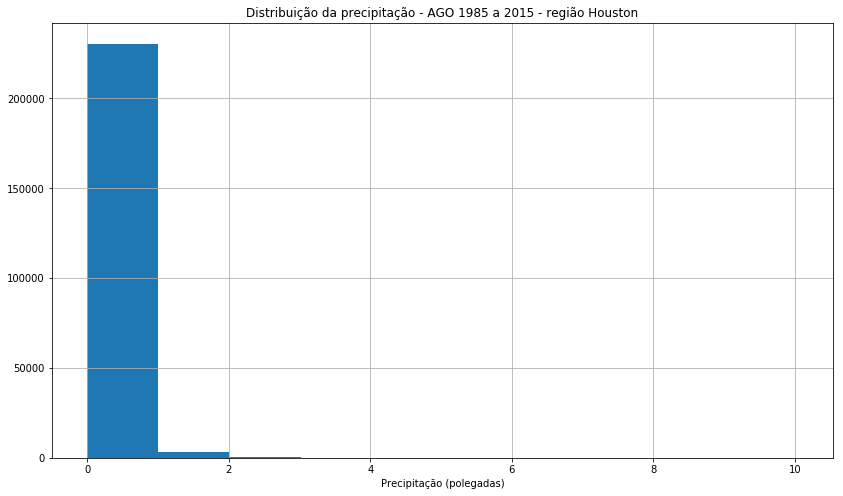

In [4]:
import matplotlib.pyplot as plt  
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]  
prcp30_limpo = df[df['d_prcp']< 99.99]
prcp30_limpo.d_prcp.hist()  
plt.title(u'Distribuição da precipitação - AGO 1985 a 2015 - região Houston')  
plt.xlabel(u'Precipitação (polegadas)')  
plt.show()  

<h3 style="color:red;">Limiar para classificar a precipitação como extrema do conjunto de treinamento e validação</h3>

In [5]:
import numpy as np
p = np.percentile(prcp30_limpo['d_prcp'], 99) # return 99%th percentile
print p

1.3


<p>Considerando os últimos 30 anos o limiar é 1.65 polegadas. Comparando com 2016 é limiar mais baixo, 2016 teve um agosto bem mais chuvoso e com mais eventos extremos que a média dos últimos anos</p>

<h3 style="color:red;">Medindo a quantidade de chuvas extremas no período</h3>

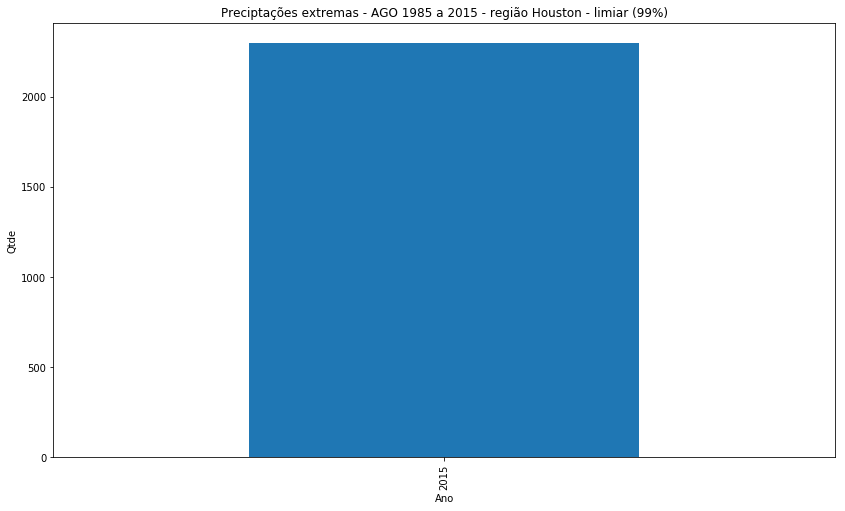

In [6]:
extreme = prcp30_limpo[prcp30_limpo['d_prcp']> 1.3] 
r = extreme.groupby(['d_year'])['d_prcp'].count()
r.plot.bar()
plt.title(u'Preciptações extremas - AGO 1985 a 2015 - região Houston - limiar (99%)')  
plt.ylabel(u'Qtde')  
plt.xlabel(u'Ano')  
plt.show()

<h2 style="color:blue;">Feature engineering</h2>

<p>O objetivo é realizar a previsão destes eventos usando as variáveis de 3 dias atrás. No estudo de Dolif Neto e Nobre (2012) foram extraídas variavéis também de 3 dias atrás dos fenômenos precipitações extremas. Assim vamos derivar as variáveis de 3 dias atrás antes do fenômeno. Inicialente <b>vamos derivar somente a precipitação</b>, testar e depois fazer para todas as varíaveis</p>

In [7]:
prcp30_limpo = prcp30_limpo.apply(pd.to_numeric, errors='coerce')  

tmp = prcp30_limpo[['d_stn','d_da','d_mo','d_year','d_prcp']]
tmp = tmp.sort_values(['d_year','d_stn','d_da'])
tmp = tmp.reset_index(drop=True)

In [8]:
N = 1 #1 dia antes
feature = 'd_prcp'

nth_prior =[]

# Devirando a variavel para uma lista representando a enesima valor da variavel, se for o primeiro dia não terá dia anterior.
for y in range(2015,2016):
  df_year = tmp[tmp['d_year']== y]
  df_year = df_year.reset_index(drop=True)
  rows = df_year.shape[0]
  prior= [None]*N + [df_year[feature][i-N] for i in range(N, rows)]
  nth_prior = nth_prior + prior
  
col_name = "{}_{}".format(feature, N)  
tmp[col_name] = nth_prior  
tmp[:10]   

,d_stn,d_da,d_mo,d_year,d_prcp,d_prcp_1
0,619760,1,7,2015,0.16,NaN
1,619760,1,6,2015,0.75,0.16
2,619760,1,8,2015,0.00,0.75
3,619760,2,8,2015,0.00,0.00
4,619760,2,7,2015,0.00,0.00
5,619760,2,6,2015,0.71,0.00
6,619760,3,8,2015,0.24,0.71
7,619760,3,6,2015,1.30,0.24
8,619760,3,7,2015,0.16,1.30
9,619760,4,7,2015,0.04,0.16


<p>Veja que para a estação ID 722430 no dia 4/8/1985, a precipitação do dia anterior (d_prcp_1) é exatamente o valor medido no dia 03/08/1985. Agora vamos fazer isto para todas as variaveis.</p>

In [9]:
def derivar_valor_anterior(df, dias, variavel):
  N = dias
  feature = variavel
  tmp = df

  nth_prior =[]

  # Devirando a variavel para uma lista representando a enesima valor da variavel, se for o primeiro dia não terá dia anterior.
  for y in range(2015,2016):
    df_year = tmp[tmp['d_year']== y]
    df_year = df_year.reset_index(drop=True)
    rows = df_year.shape[0]
    prior= [None]*N + [df_year[feature][i-N] for i in range(N, rows)]
    nth_prior = nth_prior + prior

  col_name = "{}_{}".format(feature, N)  
  tmp[col_name] = nth_prior


df_dev = df.apply(pd.to_numeric, errors='coerce')  
df_dev = df_dev.sort_values(['d_year','d_stn','d_da'])
df_dev = df_dev.reset_index(drop=True)
  
for var in list(df_dev):
  if var not in ['d_stn','d_da','d_mo','d_year','ws_lat','ws_lon']:
    for N in range(1, 4):
      derivar_valor_anterior(df_dev,N,var)

df_dev.columns 

Index([u'd_prcp', u'd_stn', u'ws_lat', u'ws_lon', u'd_da', u'd_mo', u'd_year',
       u'd_temp', u'd_dewp', u'd_slp', u'd_stp', u'd_visib', u'd_wdsp',
       u'd_mxpsd', u'd_gust', u'd_max', u'd_min', u'd_flag_prcp', u'd_sndp',
       u'd_fog', u'd_rain_drizzle', u'd_snow_ice_pellets', u'd_hail',
       u'd_thunder', u'd_tornado_funnel_cloud', u'key', u'd_prcp_1',
       u'd_prcp_2', u'd_prcp_3', u'd_temp_1', u'd_temp_2', u'd_temp_3',
       u'd_dewp_1', u'd_dewp_2', u'd_dewp_3', u'd_slp_1', u'd_slp_2',
       u'd_slp_3', u'd_stp_1', u'd_stp_2', u'd_stp_3', u'd_visib_1',
       u'd_visib_2', u'd_visib_3', u'd_wdsp_1', u'd_wdsp_2', u'd_wdsp_3',
       u'd_mxpsd_1', u'd_mxpsd_2', u'd_mxpsd_3', u'd_gust_1', u'd_gust_2',
       u'd_gust_3', u'd_max_1', u'd_max_2', u'd_max_3', u'd_min_1', u'd_min_2',
       u'd_min_3', u'd_flag_prcp_1', u'd_flag_prcp_2', u'd_flag_prcp_3',
       u'd_sndp_1', u'd_sndp_2', u'd_sndp_3', u'd_fog_1', u'd_fog_2',
       u'd_fog_3', u'd_rain_drizzle_1', u'd_rain_d

<p>Pronto! Agora temos variaveis respectivas de 1, 2, 3 dias atrás. Exemplo: d_prcp_1, d_prcp_2, d_prcp_3 referentes a precipitação 1, 2 e 3 dias atrás respectivamente.</p>

<h2 style="color:blue;">Limpeza dos dados</h2>

<p>Conforme dito anteriormente, existem muitos dados ausentes para algumas variáveis. Podemos excluir as instâncias, mas precisamos ver se perderíamos muitos dados</p>

In [10]:
df_dev = df_dev.apply(pd.to_numeric, errors='coerce')  
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255618 entries, 0 to 255617
Data columns (total 86 columns):
d_prcp                      255618 non-null float64
d_stn                       255618 non-null int64
ws_lat                      255618 non-null float64
ws_lon                      255618 non-null float64
d_da                        255618 non-null int64
d_mo                        255618 non-null int64
d_year                      255618 non-null int64
d_temp                      255618 non-null float64
d_dewp                      255618 non-null float64
d_slp                       255618 non-null float64
d_stp                       255618 non-null float64
d_visib                     255618 non-null float64
d_wdsp                      255618 non-null float64
d_mxpsd                     255618 non-null float64
d_gust                      255618 non-null float64
d_max                       255618 non-null float64
d_min                       255618 non-null float64
d_flag_prcp  

In [11]:
df_dev[:10]

,d_prcp,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,...,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3,key_1,key_2,key_3
0,0.16,619760,-15.883,54.517,1,7,2015,76.6,71.4,1016.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.75,619760,-15.883,54.517,1,6,2015,79.0,73.3,1013.7,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,0.00,619760,-15.883,54.517,1,8,2015,77.6,70.6,1017.2,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.0,0.0,NaN
3,0.00,619760,-15.883,54.517,2,8,2015,76.9,69.5,1018.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
4,0.00,619760,-15.883,54.517,2,7,2015,78.3,70.2,1018.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
5,0.71,619760,-15.883,54.517,2,6,2015,77.2,73.8,1013.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0
6,0.24,619760,-15.883,54.517,3,8,2015,73.9,66.2,1019.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,3.0
7,1.30,619760,-15.883,54.517,3,6,2015,79.7,74.2,1013.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,4.0
8,0.16,619760,-15.883,54.517,3,7,2015,77.7,72.0,1019.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,5.0
9,0.04,619760,-15.883,54.517,4,7,2015,77.9,71.3,1020.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,7.0,6.0


In [12]:
df_temp = df_dev[(df_dev < 9999.9000).all(axis=1)]
print ('Tamanho antes da limpeza: %s' %str(len(df_dev))) 
print ('Tamanho depois da limpeza: %s' %str(len(df_temp))) 

Tamanho antes da limpeza: 255618
Tamanho depois da limpeza: 0


<p>A conclusão é que todo registro tem algum dado ausente. Assim vamos verificar se tem alguma variável que apresenta maiores problemas.<p/>

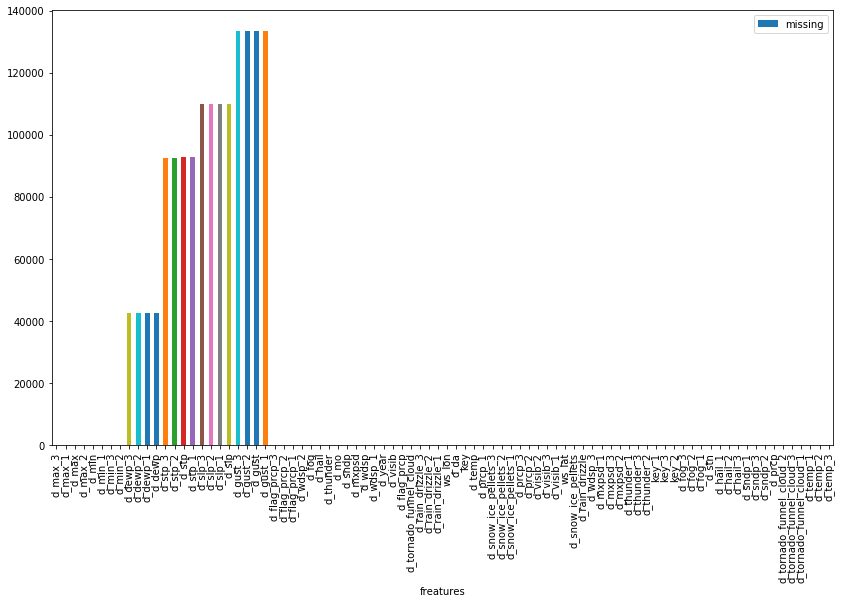

In [13]:
def contabilizar_dados_ausentes(df):
  dn = {}
  
  for v in df.columns:
    df_grp = df[df[v] == 9999.9]
    dn[v] = len(df_grp)

  for v in ['d_gust','d_gust_1', 'd_gust_2', 'd_gust_3']:
    if v in df.columns:
      df_grp = df[df[v] == 999.9]
      dn[v] = dn[v] + len(df_grp)

  for v in ['d_prcp','d_prcp_1', 'd_prcp_2', 'd_prcp_3']:
    if v in df.columns:
      df_grp = df[df[v] == 99.9]
      dn[v] = dn[v] + len(df_grp) 
    
  pdn = pd.DataFrame(dn.items(), columns=['freatures', 'missing'])
  pdn = pdn[pdn > 0]
  pdn = pdn.sort_values(['missing'])
  
  return pdn

pdn = contabilizar_dados_ausentes(df_dev)
pdn.plot.bar(x='freatures', y='missing')
plt.show()

<p> As varíveis velocidade máxima do vento do dia (d_mxpsd), velocidade do fenômeno de aumento repentino do vento (d_gust), média da velocidade do vento (d_wdsp), temperatura do ponto de orvaloho (d_dewp) e pressão atmosferica (d_stp) apresentam valores nulos significativos. Sendo a variável d_gust a mais problemática.</p>

<p>A decisão será remover velocidade do fenômeno de aumento repentino do vento (d_gust) e  pressão atmosferica (d_stp). E interpolar as demais utilizando algum método.</p>

In [14]:
df_limpo = df_dev.copy(deep=True)

for column in df_limpo.columns:
    if column in ['d_gust','d_gust_1','d_gust_2','d_gust_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_stp','d_stp_1','d_stp_2','d_stp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_flag_prcp','d_flag_prcp_1','d_flag_prcp_2','d_flag_prcp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['d_sndp','d_sndp_1','d_sndp_2','d_sndp_3']:
        df_limpo = df_limpo.drop(column, axis = 1)
        
for column in df_limpo.columns:
    if column in ['key','key_1','key_2','key_3']:
        df_limpo = df_limpo.drop(column, axis = 1)

df_limpo.columns

Index([u'd_prcp', u'd_stn', u'ws_lat', u'ws_lon', u'd_da', u'd_mo', u'd_year',
       u'd_temp', u'd_dewp', u'd_slp', u'd_visib', u'd_wdsp', u'd_mxpsd',
       u'd_max', u'd_min', u'd_fog', u'd_rain_drizzle', u'd_snow_ice_pellets',
       u'd_hail', u'd_thunder', u'd_tornado_funnel_cloud', u'd_prcp_1',
       u'd_prcp_2', u'd_prcp_3', u'd_temp_1', u'd_temp_2', u'd_temp_3',
       u'd_dewp_1', u'd_dewp_2', u'd_dewp_3', u'd_slp_1', u'd_slp_2',
       u'd_slp_3', u'd_visib_1', u'd_visib_2', u'd_visib_3', u'd_wdsp_1',
       u'd_wdsp_2', u'd_wdsp_3', u'd_mxpsd_1', u'd_mxpsd_2', u'd_mxpsd_3',
       u'd_max_1', u'd_max_2', u'd_max_3', u'd_min_1', u'd_min_2', u'd_min_3',
       u'd_fog_1', u'd_fog_2', u'd_fog_3', u'd_rain_drizzle_1',
       u'd_rain_drizzle_2', u'd_rain_drizzle_3', u'd_snow_ice_pellets_1',
       u'd_snow_ice_pellets_2', u'd_snow_ice_pellets_3', u'd_hail_1',
       u'd_hail_2', u'd_hail_3', u'd_thunder_1', u'd_thunder_2',
       u'd_thunder_3', u'd_tornado_funnel_cloud_1',
 

<p>Agora temos outras varíaveis para tratar, que ainda estão afetando muitas instâncias</p>

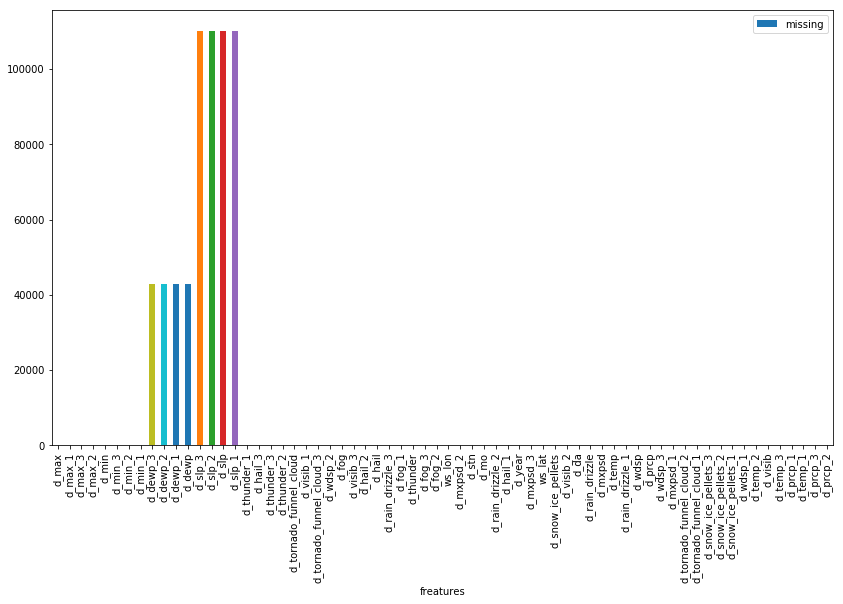

In [15]:
p = contabilizar_dados_ausentes(df_limpo)
p.plot.bar(x='freatures', y='missing')
plt.show()

<p>Primeiramente vamos marcar os dados ausentes.</p>

In [16]:
def marcar_dados_ausentes(df):
  for v in df.columns:
    df[v] = df[v].replace([9999.9],"NaN")
  for v in df.columns:
    df[v] = df[v].replace([999.9],"NaN")

marcar_dados_ausentes(df_limpo)

for v in df_limpo.columns:
  if v in ['d_prcp','d_prcp_1', 'd_prcp_2', 'd_prcp_3']:
    df_limpo[v] = df_limpo[v].replace([99.9],"NaN")

df_limpo = df_limpo.apply(pd.to_numeric, errors='coerce')  
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255618 entries, 0 to 255617
Data columns (total 66 columns):
d_prcp                      255618 non-null float64
d_stn                       255618 non-null int64
ws_lat                      255618 non-null float64
ws_lon                      255618 non-null float64
d_da                        255618 non-null int64
d_mo                        255618 non-null int64
d_year                      255618 non-null int64
d_temp                      255618 non-null float64
d_dewp                      212876 non-null float64
d_slp                       145549 non-null float64
d_visib                     196491 non-null float64
d_wdsp                      240047 non-null float64
d_mxpsd                     236561 non-null float64
d_max                       255553 non-null float64
d_min                       255523 non-null float64
d_fog                       255618 non-null int64
d_rain_drizzle              255618 non-null int64
d_snow_ice_pellet

<p>Interpolá-los</p>

<h2 style="color:blue;">Interpolandos dados para outras variáveis: dados ausentes</h2>

In [17]:
df_intptd = df_limpo.copy(deep=True)
for v in df_intptd:
  if v not in ['d_stn','d_da','d_mo','d_year']:
    df_intptd[v] = df_intptd[v].astype(float)

df_intptd = df_intptd.interpolate(method='linear', axis=0).ffill().bfill()
df_intptd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255618 entries, 0 to 255617
Data columns (total 66 columns):
d_prcp                      255618 non-null float64
d_stn                       255618 non-null int64
ws_lat                      255618 non-null float64
ws_lon                      255618 non-null float64
d_da                        255618 non-null int64
d_mo                        255618 non-null int64
d_year                      255618 non-null int64
d_temp                      255618 non-null float64
d_dewp                      255618 non-null float64
d_slp                       255618 non-null float64
d_visib                     255618 non-null float64
d_wdsp                      255618 non-null float64
d_mxpsd                     255618 non-null float64
d_max                       255618 non-null float64
d_min                       255618 non-null float64
d_fog                       255618 non-null float64
d_rain_drizzle              255618 non-null float64
d_snow_ice_pe

In [18]:
df_intptd[:10]

,d_prcp,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,0.16,619760,-15.883,54.517,1,7,2015,76.6,71.4,1016.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.75,619760,-15.883,54.517,1,6,2015,79.0,73.3,1013.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,619760,-15.883,54.517,1,8,2015,77.6,70.6,1017.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,619760,-15.883,54.517,2,8,2015,76.9,69.5,1018.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,619760,-15.883,54.517,2,7,2015,78.3,70.2,1018.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.71,619760,-15.883,54.517,2,6,2015,77.2,73.8,1013.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.24,619760,-15.883,54.517,3,8,2015,73.9,66.2,1019.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.30,619760,-15.883,54.517,3,6,2015,79.7,74.2,1013.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.16,619760,-15.883,54.517,3,7,2015,77.7,72.0,1019.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.04,619760,-15.883,54.517,4,7,2015,77.9,71.3,1020.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2 style="color:blue;">Pearson correlation coefficient</h2>

In [19]:
import seaborn as sns

In [20]:
FLAGS = ['d_fog','d_rain_drizzle','d_snow_ice_pellets','d_hail','d_thunder','d_tornado_funnel_cloud','d_fog_1','d_rain_drizzle_1','d_snow_ice_pellets_1','d_hail_1','d_thunder_1','d_tornado_funnel_cloud_1','d_fog_2','d_rain_drizzle_2','d_snow_ice_pellets_2','d_hail_2','d_thunder_2','d_tornado_funnel_cloud_2','d_fog_3','d_rain_drizzle_3','d_snow_ice_pellets_3','d_hail_3','d_thunder_3','d_tornado_funnel_cloud_3']

print (FLAGS) 

['d_fog', 'd_rain_drizzle', 'd_snow_ice_pellets', 'd_hail', 'd_thunder', 'd_tornado_funnel_cloud', 'd_fog_1', 'd_rain_drizzle_1', 'd_snow_ice_pellets_1', 'd_hail_1', 'd_thunder_1', 'd_tornado_funnel_cloud_1', 'd_fog_2', 'd_rain_drizzle_2', 'd_snow_ice_pellets_2', 'd_hail_2', 'd_thunder_2', 'd_tornado_funnel_cloud_2', 'd_fog_3', 'd_rain_drizzle_3', 'd_snow_ice_pellets_3', 'd_hail_3', 'd_thunder_3', 'd_tornado_funnel_cloud_3']


In [21]:
df_corl = df_intptd.copy(deep=True)
for v in df_corl.columns:
  if v in ['d_stn','d_da','d_mo','d_year', 'ws_lat', 'ws_lon']:
    df_corl = df_corl.drop(v, axis = 1)
    
for v in df_corl.columns:
  if v in FLAGS:
    df_corl = df_corl.drop(v, axis = 1)

df_corl[:10]

,d_prcp,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,d_max,d_min,d_prcp_1,...,d_wdsp_3,d_mxpsd_1,d_mxpsd_2,d_mxpsd_3,d_max_1,d_max_2,d_max_3,d_min_1,d_min_2,d_min_3
0,0.16,76.6,71.4,1016.4,9.3,13.3,14.0,79.9,73.2,0.16,...,13.3,14.0,14.0,14.0,79.9,79.9,79.9,73.2,73.2,73.2
1,0.75,79.0,73.3,1013.7,9.3,15.3,19.0,84.7,73.0,0.16,...,13.3,14.0,14.0,14.0,79.9,79.9,79.9,73.2,73.2,73.2
2,0.00,77.6,70.6,1017.2,9.3,9.0,12.0,82.4,75.0,0.75,...,13.3,19.0,14.0,14.0,84.7,79.9,79.9,73.0,73.2,73.2
3,0.00,76.9,69.5,1018.8,9.3,14.8,19.0,82.4,73.4,0.00,...,13.3,12.0,19.0,14.0,82.4,84.7,79.9,75.0,73.0,73.2
4,0.00,78.3,70.2,1018.1,9.3,13.6,15.0,82.6,76.3,0.00,...,15.3,19.0,12.0,19.0,82.4,82.4,84.7,73.4,75.0,73.0
5,0.71,77.2,73.8,1013.7,9.3,17.6,20.0,79.0,75.2,0.00,...,9.0,15.0,19.0,12.0,82.6,82.4,82.4,76.3,73.4,75.0
6,0.24,73.9,66.2,1019.7,9.3,17.4,22.0,75.2,70.9,0.71,...,14.8,20.0,15.0,19.0,79.0,82.6,82.4,75.2,76.3,73.4
7,1.30,79.7,74.2,1013.3,9.3,16.1,18.1,83.7,76.8,0.24,...,13.6,22.0,20.0,15.0,75.2,79.0,82.6,70.9,75.2,76.3
8,0.16,77.7,72.0,1019.5,9.3,17.3,21.0,81.7,76.3,1.30,...,17.6,18.1,22.0,20.0,83.7,75.2,79.0,76.8,70.9,75.2
9,0.04,77.9,71.3,1020.5,9.3,18.6,20.0,80.6,75.2,0.16,...,17.4,21.0,18.1,22.0,81.7,83.7,75.2,76.3,76.8,70.9


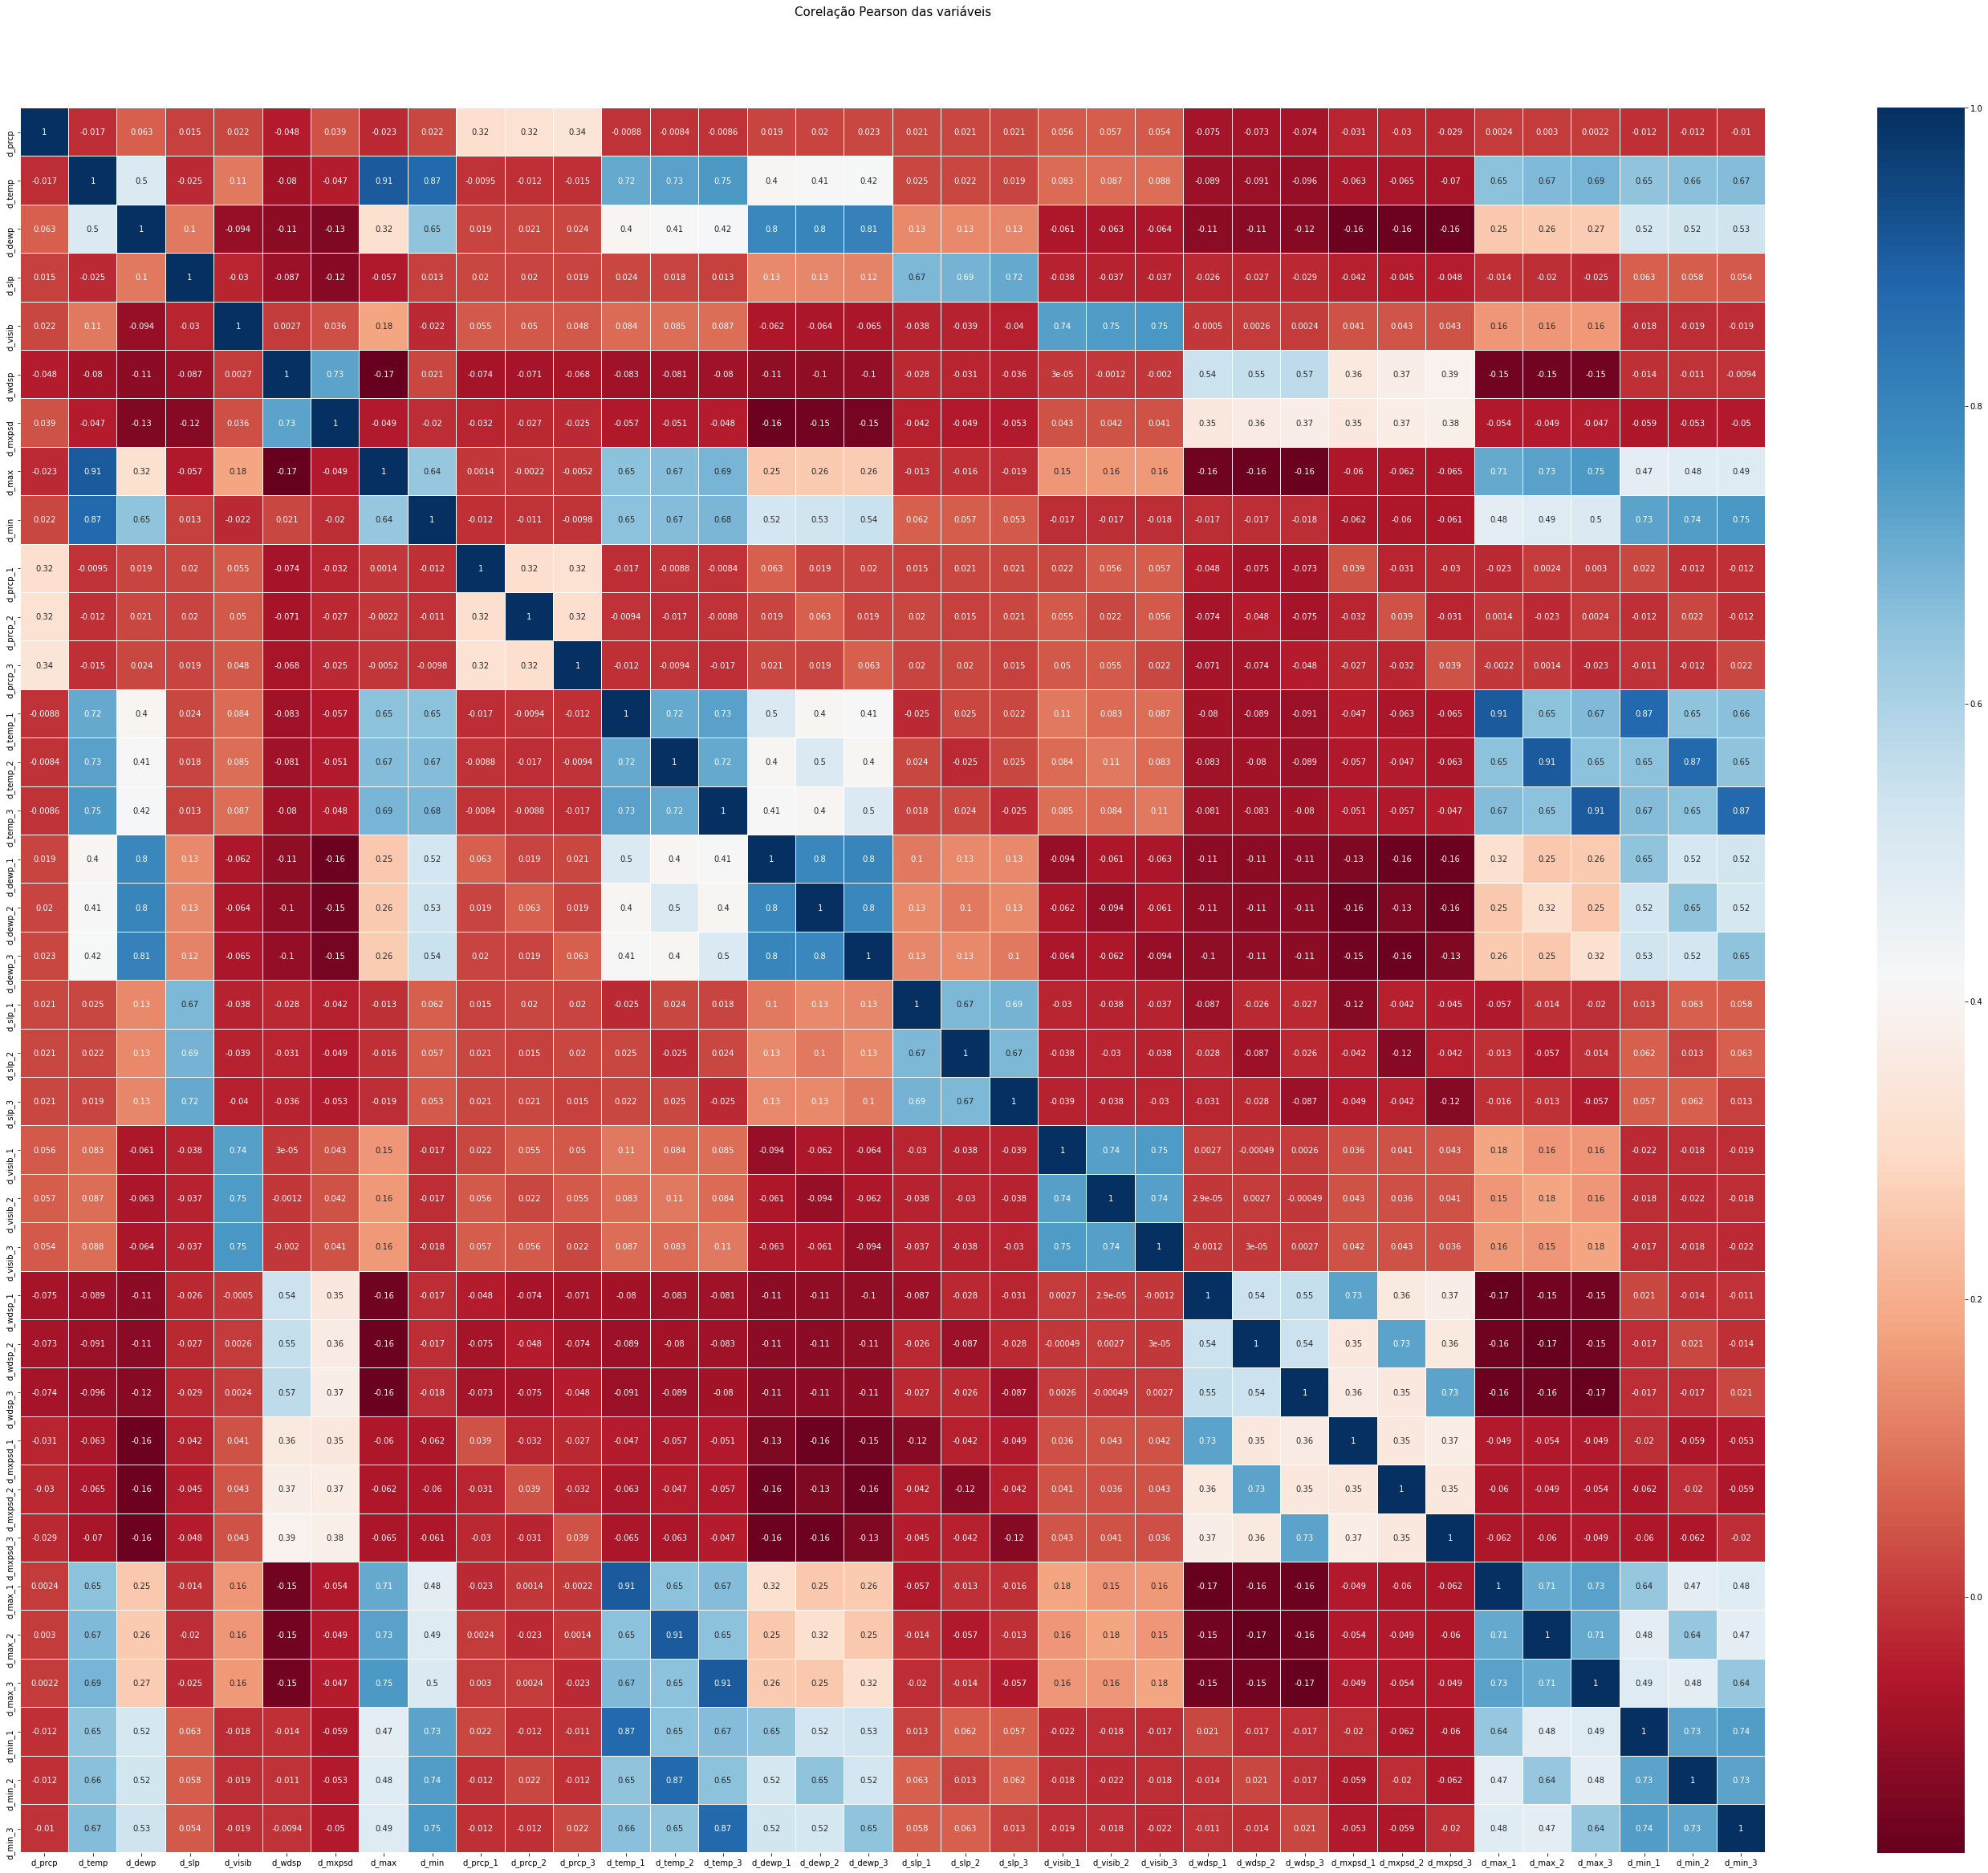

In [22]:
colormap = plt.cm.RdBu
plt.figure(figsize=(50,40))
plt.title(u'Corelação Pearson das variáveis', y=1.05, size=15)
svm = sns.heatmap(df_corl.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

fig = svm.get_figure()
name = 'pearson-all.png'
fig.savefig(name,dpi=300)

#df_corl.corr()[['d_prcp']].sort_values('d_prcp')  

<p>Nenhuma variável apresentou uma correlação alta. Assim vamos aplicar um modelo não linear.</p>

In [23]:
for v in df_corl.columns:
  if '_1' in v:  
    df_corl = df_corl.drop(v, axis = 1)
  if '_2' in v:  
    df_corl = df_corl.drop(v, axis = 1)
  if '_3' in v:  
    df_corl = df_corl.drop(v, axis = 1)
    
    
for v in df_corl.columns:
  if v in FLAGS:
    df_corl = df_corl.drop(v, axis = 1)

df_corl[:10]

,d_prcp,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,d_max,d_min
0,0.16,76.6,71.4,1016.4,9.3,13.3,14.0,79.9,73.2
1,0.75,79.0,73.3,1013.7,9.3,15.3,19.0,84.7,73.0
2,0.00,77.6,70.6,1017.2,9.3,9.0,12.0,82.4,75.0
3,0.00,76.9,69.5,1018.8,9.3,14.8,19.0,82.4,73.4
4,0.00,78.3,70.2,1018.1,9.3,13.6,15.0,82.6,76.3
5,0.71,77.2,73.8,1013.7,9.3,17.6,20.0,79.0,75.2
6,0.24,73.9,66.2,1019.7,9.3,17.4,22.0,75.2,70.9
7,1.30,79.7,74.2,1013.3,9.3,16.1,18.1,83.7,76.8
8,0.16,77.7,72.0,1019.5,9.3,17.3,21.0,81.7,76.3
9,0.04,77.9,71.3,1020.5,9.3,18.6,20.0,80.6,75.2


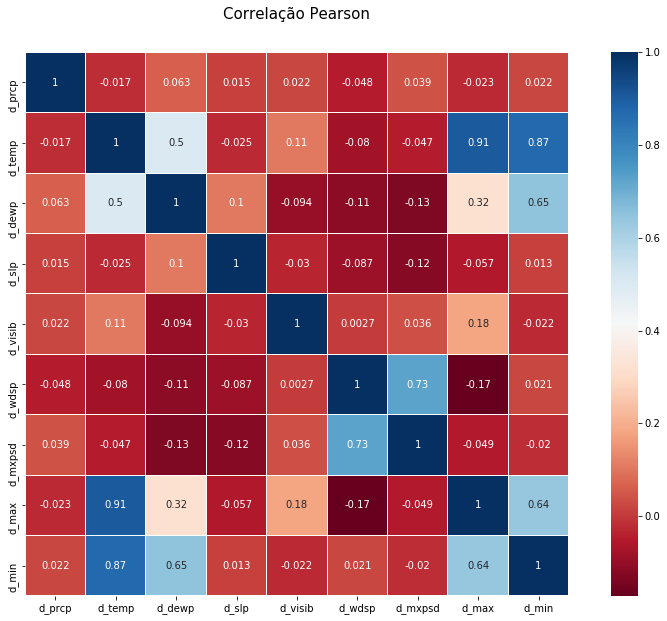

In [24]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'Correlação Pearson', y=1.05, size=15)
svm = sns.heatmap(df_corl.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

fig = svm.get_figure()
name = 'pearson-base.png'
fig.savefig(name,dpi=300)

<h2 style="color:blue;">Treinamento e validação</h2>

In [25]:
df_intptd[:10]

,d_prcp,d_stn,ws_lat,ws_lon,d_da,d_mo,d_year,d_temp,d_dewp,d_slp,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,0.16,619760,-15.883,54.517,1,7,2015,76.6,71.4,1016.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.75,619760,-15.883,54.517,1,6,2015,79.0,73.3,1013.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,619760,-15.883,54.517,1,8,2015,77.6,70.6,1017.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,619760,-15.883,54.517,2,8,2015,76.9,69.5,1018.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,619760,-15.883,54.517,2,7,2015,78.3,70.2,1018.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.71,619760,-15.883,54.517,2,6,2015,77.2,73.8,1013.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.24,619760,-15.883,54.517,3,8,2015,73.9,66.2,1019.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.30,619760,-15.883,54.517,3,6,2015,79.7,74.2,1013.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.16,619760,-15.883,54.517,3,7,2015,77.7,72.0,1019.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.04,619760,-15.883,54.517,4,7,2015,77.9,71.3,1020.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Colocando a variável alvo na primeira posição do dataframe</p>

In [26]:
TARGET = u'd_prcp'
#TARGET = u'heavy'

cols = list(df_intptd)
cols.remove(TARGET)
cols.insert(0, TARGET)
print (cols) 

[u'd_prcp', 'd_stn', 'ws_lat', 'ws_lon', 'd_da', 'd_mo', 'd_year', 'd_temp', 'd_dewp', 'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', 'd_fog', 'd_rain_drizzle', 'd_snow_ice_pellets', 'd_hail', 'd_thunder', 'd_tornado_funnel_cloud', 'd_prcp_1', 'd_prcp_2', 'd_prcp_3', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', 'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', 'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', 'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', 'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3', 'd_fog_1', 'd_fog_2', 'd_fog_3', 'd_rain_drizzle_1', 'd_rain_drizzle_2', 'd_rain_drizzle_3', 'd_snow_ice_pellets_1', 'd_snow_ice_pellets_2', 'd_snow_ice_pellets_3', 'd_hail_1', 'd_hail_2', 'd_hail_3', 'd_thunder_1', 'd_thunder_2', 'd_thunder_3', 'd_tornado_funnel_cloud_1', 'd_tornado_funnel_cloud_2', 'd_tornado_funnel_cloud_3']


In [27]:
for v in df_intptd.columns:
  if v in ['d_da','d_mo','d_year']:
    df_intptd = df_intptd.drop(v, axis = 1)

In [28]:
df_intptd[:12]

,d_prcp,d_stn,ws_lat,ws_lon,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,0.16,619760,-15.883,54.517,76.6,71.4,1016.4,9.3,13.3,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.75,619760,-15.883,54.517,79.0,73.3,1013.7,9.3,15.3,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,619760,-15.883,54.517,77.6,70.6,1017.2,9.3,9.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,619760,-15.883,54.517,76.9,69.5,1018.8,9.3,14.8,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,619760,-15.883,54.517,78.3,70.2,1018.1,9.3,13.6,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.71,619760,-15.883,54.517,77.2,73.8,1013.7,9.3,17.6,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.24,619760,-15.883,54.517,73.9,66.2,1019.7,9.3,17.4,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.30,619760,-15.883,54.517,79.7,74.2,1013.3,9.3,16.1,18.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.16,619760,-15.883,54.517,77.7,72.0,1019.5,9.3,17.3,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.04,619760,-15.883,54.517,77.9,71.3,1020.5,9.3,18.6,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
FEATURES = df_intptd.columns.tolist()
SPARSE = ['d_stn',]
BUCKET = ['ws_lat','ws_lon']

for f in FLAGS:
  FEATURES.remove(f)

for s in SPARSE:
    FEATURES.remove(s)

for b in BUCKET:
    FEATURES.remove(b)
    
FEATURES.remove(TARGET)

print FEATURES


['d_temp', 'd_dewp', 'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', 'd_prcp_1', 'd_prcp_2', 'd_prcp_3', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', 'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', 'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', 'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', 'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3']


In [30]:
print FLAGS

['d_fog', 'd_rain_drizzle', 'd_snow_ice_pellets', 'd_hail', 'd_thunder', 'd_tornado_funnel_cloud', 'd_fog_1', 'd_rain_drizzle_1', 'd_snow_ice_pellets_1', 'd_hail_1', 'd_thunder_1', 'd_tornado_funnel_cloud_1', 'd_fog_2', 'd_rain_drizzle_2', 'd_snow_ice_pellets_2', 'd_hail_2', 'd_thunder_2', 'd_tornado_funnel_cloud_2', 'd_fog_3', 'd_rain_drizzle_3', 'd_snow_ice_pellets_3', 'd_hail_3', 'd_thunder_3', 'd_tornado_funnel_cloud_3']


In [31]:
print SPARSE

['d_stn']


In [76]:
TRAIN_SIZE = int(0.7*len(df_intptd))
df_train = df_intptd[:TRAIN_SIZE]
df_valid = df_intptd[TRAIN_SIZE:]
df_train[:10]

,d_prcp,d_stn,ws_lat,ws_lon,d_temp,d_dewp,d_slp,d_visib,d_wdsp,d_mxpsd,...,d_snow_ice_pellets_3,d_hail_1,d_hail_2,d_hail_3,d_thunder_1,d_thunder_2,d_thunder_3,d_tornado_funnel_cloud_1,d_tornado_funnel_cloud_2,d_tornado_funnel_cloud_3
0,0.16,619760,-15.883,54.517,76.6,71.4,1016.4,9.3,13.3,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.75,619760,-15.883,54.517,79.0,73.3,1013.7,9.3,15.3,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,619760,-15.883,54.517,77.6,70.6,1017.2,9.3,9.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,619760,-15.883,54.517,76.9,69.5,1018.8,9.3,14.8,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,619760,-15.883,54.517,78.3,70.2,1018.1,9.3,13.6,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.71,619760,-15.883,54.517,77.2,73.8,1013.7,9.3,17.6,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.24,619760,-15.883,54.517,73.9,66.2,1019.7,9.3,17.4,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.30,619760,-15.883,54.517,79.7,74.2,1013.3,9.3,16.1,18.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.16,619760,-15.883,54.517,77.7,72.0,1019.5,9.3,17.3,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.04,619760,-15.883,54.517,77.9,71.3,1020.5,9.3,18.6,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
import tensorflow as tf
import shutil

print tf.__version__

1.4.1


<h3 style="color:red;">Funções para ler o dataframe para inserir no tf.constant</h3>

In [109]:
def make_input_fn(df):
  def pandas_to_tf(pdcol):
    #convert the pandas column values to float
    t = tf.constant(pdcol.astype('float32').values)
    #if pdcol in SPARSE:
    #    t = tf.constant(pdcol.astype('int64').values)
    # take the column which is of shape (N) and make it (N, 1)
    return tf.expand_dims(t, -1)
  
  def input_fn():
    # create features, columns
    ALL = FEATURES + SPARSE
    print ALL
    features = {k: pandas_to_tf(df[k]) for k in ALL}
    labels = tf.constant(df[TARGET].values)
    return features, labels
  return input_fn
  
def make_feature_cols():
    input_columns = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]
    for c in SPARSE:
        #gp = df.groupby(c)
        #keys = gp.groups.keys()
        input_columns = input_columns + [tf.contrib.layers.sparse_column_with_integerized_feature(c,6)]
        
    #latbuckets = np.linspace(32.0, 42.0, nbuckets).tolist()
    #discrete_lat = layers.bucketized_column(lat, latbuckets)
    for cc in  input_columns:
        print cc
    return input_columns

<h3 style="color:green;">Regressão Linear</h3>

In [110]:
tf.logging.set_verbosity(tf.logging.ERROR)
shutil.rmtree('prcp', ignore_errors=True) # start fresh each time
model = tf.contrib.learn.LinearRegressor(feature_columns=make_feature_cols(), model_dir='prcp')


_RealValuedColumn(column_name='d_temp', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_dewp', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_slp', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_visib', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_wdsp', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_mxpsd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_max', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_min', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_name='d_prcp_1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None)
_RealValuedColumn(column_na

In [111]:
model.fit(input_fn=make_input_fn(df_train), steps=100);

['d_temp', 'd_dewp', 'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', 'd_prcp_1', 'd_prcp_2', 'd_prcp_3', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', 'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', 'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', 'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', 'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3', 'd_stn']


TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: int32, int64

In [37]:
def print_rmse(model, name, input_fn):
  metrics = model.evaluate(input_fn=input_fn, steps=1)
  print u'RMSE(Root Mean Squared Error) no {} = {}'.format(name, np.sqrt(metrics['loss']))
  
print_rmse(model, u'conjunto de validação', make_input_fn(df_valid))

RMSE(Root Mean Squared Error) no conjunto de validação = 20.5128078461


In [38]:
model = tf.contrib.learn.LinearRegressor(feature_columns=make_feature_cols(), model_dir='prcp')
preds = model.predict(input_fn=make_input_fn(df_valid))
m = list(preds)

['d_stn', 'ws_lat', 'ws_lon', 'd_temp', 'd_dewp', 'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', 'd_prcp_1', 'd_prcp_2', 'd_prcp_3', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', 'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', 'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', 'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', 'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3']


<p>Comparando as predições com o conjunto de validação.</p>

In [39]:
df_comparar = df_valid.copy(deep=True)
df_comparar = df_comparar.reset_index(drop=True)

df_comparar['resultado'] = m

cols = list(df_comparar)
cols.insert(0, cols.pop(cols.index('resultado')))
df_comparar = df_comparar.ix[:, cols]

print df_comparar[:10]

   resultado  d_prcp   d_stn  ws_lat   ws_lon  d_temp  d_dewp   d_slp  \
0  10.684286    0.00  727690  48.603 -112.375    52.7    43.4  1023.0   
1  10.683581    0.00  727690  48.603 -112.375    57.3    37.8  1017.3   
2  10.684066    0.00  727690  48.603 -112.375    58.8    41.2  1014.9   
3  10.683832    0.09  727690  48.603 -112.375    56.0    46.3  1020.1   
4  10.683820    0.08  727690  48.603 -112.375    50.0    42.5  1012.9   
5  10.684004    0.07  727690  48.603 -112.375    58.5    47.5  1015.9   
6  10.684234    0.06  727690  48.603 -112.375    60.1    44.0  1016.6   
7  10.684184    0.15  727690  48.603 -112.375    58.2    45.2  1018.0   
8  10.684621    0.00  727690  48.603 -112.375    64.8    40.9  1009.2   
9  10.684517    0.00  727690  48.603 -112.375    66.4    43.2  1014.0   

   d_visib  d_wdsp            ...             d_snow_ice_pellets_3  d_hail_1  \
0      9.9     5.9            ...                              0.0       0.0   
1     10.0     4.2            ...   

/home/dedeco/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  



<p><b>Root Mean Square Error (RMSE)</b> is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Root mean square error is commonly used in climatology, forecasting, and regression analysis to verify experimental results.</P>

<h3 style="color:green;"> Deep Neural Network regression </h3>

In [40]:
shutil.rmtree('prcp', ignore_errors=True)
model = tf.contrib.learn.DNNRegressor(hidden_units=[32, 8, 2], feature_columns=make_feature_cols(), 
                                      optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.3,l1_regularization_strength=0.001),
                                      model_dir='prcp', )
model.fit(input_fn=make_input_fn(df_train), steps=500);
print_rmse(model, u'conjunto de validação', make_input_fn(df_valid))
preds = model.predict(input_fn=make_input_fn(df_valid))
m = list(preds)

['d_stn', 'ws_lat', 'ws_lon', 'd_temp', 'd_dewp', 'd_slp', 'd_visib', 'd_wdsp', 'd_mxpsd', 'd_max', 'd_min', 'd_prcp_1', 'd_prcp_2', 'd_prcp_3', 'd_temp_1', 'd_temp_2', 'd_temp_3', 'd_dewp_1', 'd_dewp_2', 'd_dewp_3', 'd_slp_1', 'd_slp_2', 'd_slp_3', 'd_visib_1', 'd_visib_2', 'd_visib_3', 'd_wdsp_1', 'd_wdsp_2', 'd_wdsp_3', 'd_mxpsd_1', 'd_mxpsd_2', 'd_mxpsd_3', 'd_max_1', 'd_max_2', 'd_max_3', 'd_min_1', 'd_min_2', 'd_min_3']
RMSE(Root Mean Squared Error) no conjunto de validação = 18.2763347626


In [41]:
df_comparar = df_valid.copy(deep=True)
df_comparar = df_comparar.reset_index(drop=True)

df_comparar['resultado'] = m

cols = list(df_comparar)
cols.insert(0, cols.pop(cols.index('resultado')))
df_comparar = df_comparar.ix[:, cols]

print df_comparar[:10]

   resultado  d_prcp   d_stn  ws_lat   ws_lon  d_temp  d_dewp   d_slp  \
0   9.081462    0.00  727690  48.603 -112.375    52.7    43.4  1023.0   
1   9.081462    0.00  727690  48.603 -112.375    57.3    37.8  1017.3   
2   9.081462    0.00  727690  48.603 -112.375    58.8    41.2  1014.9   
3   9.081462    0.09  727690  48.603 -112.375    56.0    46.3  1020.1   
4   9.081462    0.08  727690  48.603 -112.375    50.0    42.5  1012.9   
5   9.081462    0.07  727690  48.603 -112.375    58.5    47.5  1015.9   
6   9.081462    0.06  727690  48.603 -112.375    60.1    44.0  1016.6   
7   9.081462    0.15  727690  48.603 -112.375    58.2    45.2  1018.0   
8   9.081462    0.00  727690  48.603 -112.375    64.8    40.9  1009.2   
9   9.081462    0.00  727690  48.603 -112.375    66.4    43.2  1014.0   

   d_visib  d_wdsp            ...             d_snow_ice_pellets_3  d_hail_1  \
0      9.9     5.9            ...                              0.0       0.0   
1     10.0     4.2            ...   

/home/dedeco/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


<h2 style="color:blue;">Conclusão</h2>

<p>Os resultados não foram bons, visto que são viciados, mas a proposta é rodar novamente mas desta vez aplicando validação cruzada. E refazer o holdout mas feito corretamente, ou seja, selecionar randomicamente. Aplicando o modelo regressão linear o <b>RMSE(Root Mean Squared Error) foi 22.68 </b> e aplicando redes neurais <b>(DNN Regressor) foi 24.66 </b>.</p>

<p>Os próximos passos são fazer o balanciamento, e possivelmente discretizar a chuva extrema em intervalos ao inves de prever a precipitação em valores contínuos. E selecionar as instâncias de forma randômica.</p>

